In [ ]:
pip install catboost

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,matthews_corrcoef


from catboost import CatBoostClassifier

In [ ]:
df = pd.read_csv('features_df.csv')
df.head(5)

,Date,Time,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HST,...,PAR,TBGH,TBGA,NOWH,NOWA,ATBGH,ATBGA,HomeMomentum,AwayMomentum,AwayDistTravelled
0,2019-08-09 00:00:00,20:00,Liverpool,Norwich,H,4,1,15,12,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,299.333504
1,2019-08-10 00:00:00,12:30,West Ham,Man City,A,0,5,5,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,261.859501
2,2019-08-10 00:00:00,15:00,Bournemouth,Sheffield United,D,1,1,13,8,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,294.104601
3,2019-08-10 00:00:00,15:00,Burnley,Southampton,H,3,0,10,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,325.615515
4,2019-08-10 00:00:00,15:00,Crystal Palace,Everton,D,0,0,6,10,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,299.376753


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 82 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            1140 non-null   object 
 1   Time                            1140 non-null   object 
 2   HomeTeam                        1140 non-null   object 
 3   AwayTeam                        1140 non-null   object 
 4   FTR                             1140 non-null   object 
 5   FTHG                            1140 non-null   int64  
 6   FTAG                            1140 non-null   int64  
 7   HS                              1140 non-null   int64  
 8   AS                              1140 non-null   int64  
 9   HST                             1140 non-null   int64  
 10  AST                             1140 non-null   int64  
 11  HC                              1140 non-null   int64  
 12  AC                              11

In [ ]:
basic_features = ['TMKO', 'AFTHG', 'AHS',
       'AHST', 'AHC', 'AHF', 'AHY', 'AHR', 'AFTAG', 'AAS', 'AAST', 'AAC',
       'AAF', 'AAY', 'AAR', 'PHFR_Won', 'PHFR_NotWin', 'PAFR_Won',
       'PAFR_NotWin', 'PFTHG', 'PHS', 'PHST', 'PHC', 'PHF', 'PHY', 'PHR',
       'PFTAG', 'PAS', 'PAST', 'PAC', 'PAF', 'PAY', 'PAR', 'TBGH', 'TBGA',
       'NOWH', 'NOWA',]

In [ ]:
weather_start = ['Start_Temp_C', 'Start_Wind_kmh', 'Start_Wind_Degree', 'Start_Humidity', 'Start_Precip_mm', 'Start_Conditions_clear_sky',
       'Start_Conditions_cloudy', 'Start_Conditions_fog',
       'Start_Conditions_heavy_rain', 'Start_Conditions_moderate_rain',
       'Start_Conditions_rain', 'Start_Conditions_snow',
       'Start_Conditions_thunderstorm',]

In [ ]:
weather_end = ['End_Conditions_clear_sky',
       'End_Conditions_cloudy', 'End_Conditions_fog',
       'End_Conditions_heavy_rain', 'End_Conditions_moderate_rain',
       'End_Conditions_rain', 'End_Conditions_snow',]

In [ ]:
features_added = ['HomeMomentum', 'AwayMomentum',
                  'AwayDistTravelled'
                  ]

In [ ]:
features = (basic_features
            +weather_start
            + weather_end
            + features_added
)

# Rolling window

In [ ]:
df = pd.read_csv('features_df.csv')
df = df.dropna().copy()
df = df.sort_values('Date').reset_index(drop=True)

df['HomeWin_Binary'] = df['FTR'].apply(lambda x: 1 if x == 'H' else 0)

target = 'HomeWin_Binary'

# --- window and step size definition ---
window_size = 380
step_size = 340

predictions = []
true_values = []

In [ ]:
df.columns

Index(['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'HS',
       'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',
       'Start_Temp_C', 'Start_Wind_kmh', 'Start_Wind_Degree', 'Start_Humidity',
       'Start_Precip_mm', 'match_id', 'Start_Conditions_clear_sky',
       'Start_Conditions_cloudy', 'Start_Conditions_fog',
       'Start_Conditions_heavy_rain', 'Start_Conditions_moderate_rain',
       'Start_Conditions_rain', 'Start_Conditions_snow',
       'Start_Conditions_thunderstorm', 'End_Conditions_clear_sky',
       'End_Conditions_cloudy', 'End_Conditions_fog',
       'End_Conditions_heavy_rain', 'End_Conditions_moderate_rain',
       'End_Conditions_rain', 'End_Conditions_snow', 'TMKO', 'AFTHG', 'AHS',
       'AHST', 'AHC', 'AHF', 'AHY', 'AHR', 'AFTAG', 'AAS', 'AAST', 'AAC',
       'AAF', 'AAY', 'AAR', 'PHFR_Won', 'PHFR_NotWin', 'PAFR_Won',
       'PAFR_NotWin', 'PFTHG', 'PHS', 'PHST', 'PHC', 'PHF', 'PHY', 'PHR',
       'PFTAG', 'PAS', 'PAST', '

In [ ]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import svm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
import pandas as pd


# Definition of models
models = {
    "LogisticRegression": LogisticRegression(C=1.0, solver='liblinear'),
    "RandomForest": RandomForestClassifier(max_depth=5,
        min_samples_split=2,
        min_samples_leaf=5,
        n_estimators= 50,
        max_features=0.8,
        max_samples= 1.0,
        random_state=42),
    "SVM": svm.SVC(C=0.1, class_weight= "balanced", kernel='rbf', gamma= 0.01, probability=True),
    "XGBoost": XGBClassifier(
        n_estimators=150,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree = 1.0,
        reg_lambda = 10,
        random_state=42),
    "Gradient Boosting (GBM)": GradientBoostingClassifier(
        max_depth=4,
        learning_rate= 0.1387,
        subsample=0.623,
        random_state=42),
    "LightGBM": LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1387,
        num_leaves=42,
        min_child_samples=57,
        subsample=0.623,
        colsample_bytree=0.634,
        reg_lambda=2.89,
        max_depth=-4,
        random_state=42,
        verbose=-1),
    "CatBoost": CatBoostClassifier(silent=True, random_state=42, depth=10,
        l2_leaf_reg=9,
        learning_rate=0.03,),
}

# Saving the results
all_model_results = []

print(f"Start rolling window comparison (window size: {window_size}, step size: {step_size})...")

# Rolling Window Loop
for i in range(window_size, len(df), step_size):
    train_start_index = i - window_size
    train_end_index = i
    test_end_index = min(i + step_size, len(df))

    if test_end_index <= train_end_index:
        break

    # Daten Slicen
    X_train = df.iloc[train_start_index : train_end_index][features]
    y_train = df.iloc[train_start_index : train_end_index][target]
    X_test = df.iloc[train_end_index : test_end_index][features]
    y_test = df.iloc[train_end_index : test_end_index][target]

    # 2. Loop over all models in window
    for name, clf in models.items():
        # Pipeline creation (Scaler + Modell)
        model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clf)
        ])

        # Training
        model_pipeline.fit(X_train, y_train)

        # Prediction
        preds = model_pipeline.predict(X_test)

        # Metric calculation
        acc = accuracy_score(y_test, preds)
        mcc = matthews_corrcoef(y_test, preds)

        # save results for each step size
        all_model_results.append({
            "Window_End": i,
            "Model": name,
            "Accuracy": acc,
            "MCC": mcc
        })

    print(f"Index {i}: Window processed for {list(models.keys())}")

# 3. Convert the evaluation into a DataFrame
results_df = pd.DataFrame(all_model_results)

# Calculate average performance per model
summary = results_df.groupby("Model")[["Accuracy", "MCC"]].mean().sort_values(by="Accuracy", ascending=False)
print("\n--- Comparison of models (average across all windows)) ---")
print(summary)
summary.to_csv(f"summary_{window_size}_{step_size}.csv", index=True)


Start rolling window comparison (window size: 380, step size: 340)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Index 380: Window processed for ['LogisticRegression', 'RandomForest', 'SVM', 'XGBoost', 'Gradient Boosting (GBM)', 'LightGBM', 'CatBoost']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Index 720: Window processed for ['LogisticRegression', 'RandomForest', 'SVM', 'XGBoost', 'Gradient Boosting (GBM)', 'LightGBM', 'CatBoost']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Index 1060: Window processed for ['LogisticRegression', 'RandomForest', 'SVM', 'XGBoost', 'Gradient Boosting (GBM)', 'LightGBM', 'CatBoost']

--- Comparison of models (average across all windows)) ---
                         Accuracy       MCC
Model                                      
SVM                      0.643514  0.220033
XGBoost                  0.621946  0.189744
LightGBM                 0.610608  0.189403
RandomForest             0.610458  0.189231
Gradient Boosting (GBM)  0.599397  0.170242
CatBoost                 0.596305  0.143385
LogisticRegression       0.526119  0.014198


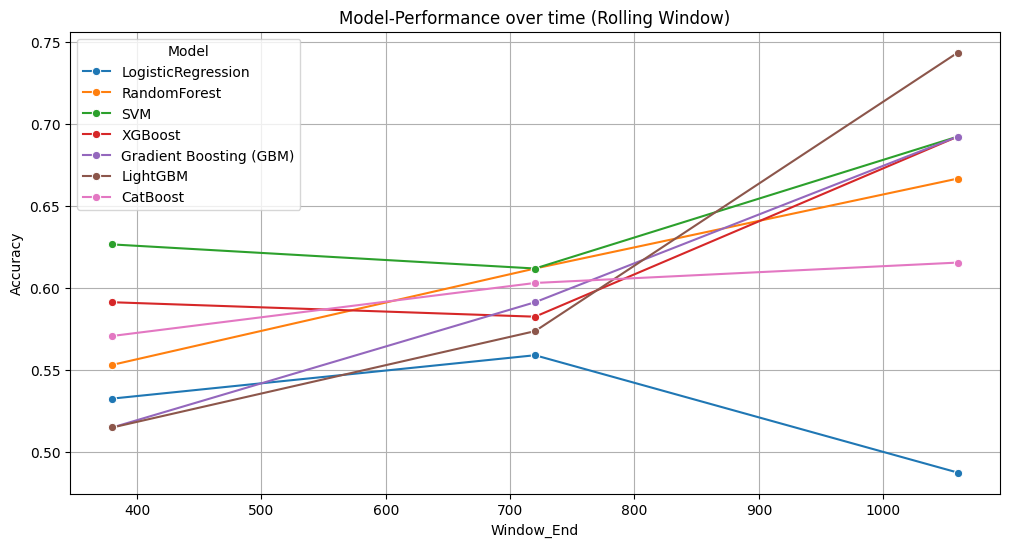

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="Window_End", y="Accuracy", hue="Model", marker="o")
plt.title("Model-Performance over time (Rolling Window)")
plt.grid(True)
plt.show()